<a href="https://colab.research.google.com/github/iloughlimi9/iloughlimi9/blob/main/Decisiontree_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Random Forest / Boosting appliqués au Titanic

## import des librairies

In [53]:
import pandas as pd
import numpy as np
import os

from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

## 1. Lecture des fichiers de données
1.1 Lire le Dataframe train (avec le champs Survived). Afficher les 10 premières lignes.

In [54]:
dataframe_train= pd.read_csv('/content/train_clean.csv')
dataframe_train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,1,0,3,1,22.0,7.2500,0,0,1
1,2,1,1,0,38.0,71.2833,1,0,3
2,3,1,3,0,26.0,7.9250,0,1,2
3,4,1,1,0,35.0,53.1000,0,0,3
4,5,0,3,1,35.0,8.0500,0,1,1
5,6,0,3,1,41.0,8.4583,2,1,1
6,7,0,1,1,54.0,51.8625,0,1,1
7,8,0,3,1,2.0,21.0750,0,0,4
8,9,1,3,0,27.0,11.1333,0,0,3
9,10,1,2,0,14.0,30.0708,1,0,3


1.2 Lire le Dataframe test (sans le champs Survived) dans les fichiers test_clean.csv. Afficher les 10 premières lignes.

In [55]:
dataframe_test= pd.read_csv('/content/test_clean.csv')
dataframe_test.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,892,3,1,34.5,7.8292,2,1,1
1,893,3,0,47.0,7.0000,0,0,3
2,894,2,1,62.0,9.6875,2,1,1
3,895,3,1,27.0,8.6625,0,1,1
4,896,3,0,22.0,12.2875,0,0,3
5,897,3,1,14.0,9.2250,0,1,1
6,898,3,0,30.0,7.6292,2,1,2
7,899,2,1,26.0,29.0000,0,0,1
8,900,3,0,18.0,7.2292,1,1,3
9,901,3,1,21.0,24.1500,0,0,1


##  Préparation des données de Training

1.3 Charger les features d'apprentissage dans un array numpy X_alltrain. Afficher le type de X_alltrain les 10 premières lignes.

In [56]:
X_alltrain = dataframe_train.drop(['Survived', 'PassengerId'], axis=1).values

type(X_alltrain)

print(X_alltrain[:10])

[[ 3.      1.     22.      7.25    0.      0.      1.    ]
 [ 1.      0.     38.     71.2833  1.      0.      3.    ]
 [ 3.      0.     26.      7.925   0.      1.      2.    ]
 [ 1.      0.     35.     53.1     0.      0.      3.    ]
 [ 3.      1.     35.      8.05    0.      1.      1.    ]
 [ 3.      1.     41.      8.4583  2.      1.      1.    ]
 [ 1.      1.     54.     51.8625  0.      1.      1.    ]
 [ 3.      1.      2.     21.075   0.      0.      4.    ]
 [ 3.      0.     27.     11.1333  0.      0.      3.    ]
 [ 2.      0.     14.     30.0708  1.      0.      3.    ]]


1.4 Charger les labels dans un array numpy y_alltrain. Afficher les 10 premières lignes.

In [57]:
y_alltrain = dataframe_train['Survived'].values

print(y_alltrain[:10])

[0 1 1 1 0 0 0 0 1 1]


1.5 Séparer les features et les labels en deux parties (train et dev). afficher les nombres de lignes et de colonnes pour les 4 arrays.

In [58]:
X_train, X_dev, y_train, y_dev = train_test_split(X_alltrain, y_alltrain, test_size=0.2, random_state=1)

print("La taille de X_train est :", X_train.shape)
print("La taille de y_train est  :", y_train.shape)
print("La taille de X_dev est :", X_dev.shape)
print("La taille de y_dev est :", y_dev.shape)

La taille de X_train est : (712, 7)
La taille de y_train est  : (712,)
La taille de X_dev est : (179, 7)
La taille de y_dev est : (179,)


1.6 Afficher les noms des features.

In [59]:
feature_names = dataframe_train.columns.drop(['Survived', 'PassengerId']).tolist()
feature_names

['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'IsAlone', 'Title']

## Fonction Utilitaires

In [ ]:
# Fonctions permettant de générer le fichier d'envoi à Kaggle
#parametres: Classifiers; Données à calculer ; index)

def generer_resultats(clf,df_test=test):
    """
    Fonctions permettant de générer le fichier d'envoi à Kaggle.
    On passe un classifier sur lequel on refait le training avec toutes les données de training
    
    Parameters
    ----------
    Classifiers : Classifier utilisé pour la prédiction
    data : Données à calculer. par défaut, les valeurs du dataset "test"
    idx : Index des passagers testés. Stockés dans finalfile_index lors de la lecture des données
    """    
    data = df_test.iloc[:,1:].values
    idx = df_test.PassengerId
    print(clf.get_params())
    clf.fit(X_alltrain, y_alltrain)
    prediction=clf.predict(data)
    results=pd.DataFrame(prediction.astype(int), index = df_test.PassengerId, columns=['Survived'])
    results.to_csv('resultats%s.csv'%clf.__class__.__name__)
    
#Fonction pour l'affichage 2 D des résultats    

def plot_decision_boundary(clf,X,y, axes=[0, 85, 0, 300], axis_name=['x1','x2'],alpha=0.5, contour=True):
    """
    Fonction pour l'affichage 2 D des résultats   
    
    Parameters
    ----------
    clf : Classifier à afficher
    X : features de Données a afficher
    y : labels de Données a afficher  
    axes : : Tailles des axes (valeur min/max)
    axis_name : Nom des axes sur le graphique
    alpha : Transparence des points
    contour : Afichage du contour
    """     
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    

    df_X_y = pd.concat([pd.DataFrame(X,columns=['f1','f2']),pd.DataFrame(y,columns=['label'])],axis=1)
    plt.plot(
        df_X_y.loc[df_X_y.label==0,'f1'].values, 
        df_X_y.loc[df_X_y.label==0,'f2'].values, 
        "ro", label="Disparu", 
        alpha=alpha
        ) 
    plt.plot(
        df_X_y.loc[df_X_y.label==1,'f1'].values, 
        df_X_y.loc[df_X_y.label==1,'f2'].values, 
        "gs", label="Rescapé", 
        alpha=alpha
        ) 

    plt.axis(axes)
    plt.xlabel(axis_name[0], fontsize=18)
    plt.ylabel(axis_name[1]+ "  ",fontsize=18, rotation=0)   
    plt.legend(loc="lower right", fontsize=14)

## Exercice 2 : Arbre de Décision
2.1 En utilisant l'exemple 1, contruisez et entrainez un arbre de décision pour prévoir la survie. <br>

In [60]:
# Créer un classifieur d'arbre de décision avec les paramètres par défaut
tree_clf = DecisionTreeClassifier(random_state=42)

# Entraîner l'arbre de décision sur les données d'apprentissage
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

2.2 Appliquer le modèle sur vos données de dev

In [61]:
# Prédire les labels pour les données de développement
y_dev_pred = tree_clf.predict(X_dev)

# Afficher le score d'exactitude sur les données de développement
print("Score sur les données de développement : {:.2f}%".format(accuracy_score(y_dev, y_dev_pred)*100))

Score sur les données de développement : 76.54%


2.3 : Essayez plusieurs valeurs pour max_depth et garder le meilleur résultat
Vous pouvez aussi tester d'autres paramètres disponible sur https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier

In [62]:
# Initialiser les variables pour stocker les meilleurs résultats
best_score = 0
best_depth = None

# Boucle sur les différentes valeurs de max_depth
for depth in range(1,17):
    
    # Créer un classifieur d'arbre de décision avec la valeur actuelle de max_depth
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Entraîner l'arbre de décision sur les données d'apprentissage
    tree_clf.fit(X_train, y_train)
    
    # Prédire les labels pour les données de développement
    y_dev_pred = tree_clf.predict(X_dev)

    # Calculer le score d'exactitude pour les données de développement
    score = accuracy_score(y_dev, y_dev_pred)
    
    # Afficher le score pour la valeur actuelle de max_depth
    print("max_depth = {}, Score sur les données de développement : {:.2f}%".format(depth, score*100))
    
    # Mettre à jour les variables pour stocker le meilleur résultat
    if score > best_score:
        best_score = score
        best_depth = depth

# Afficher la meilleure valeur de max_depth et son score correspondant
print("Meilleure valeur de max_depth : {}, Score correspondant sur les données de développement : {:.2f}%".format(best_depth, best_score*100))

# Créer un classifieur d'arbre de décision avec la valeur actuelle de max_depth
tree_clf = DecisionTreeClassifier(max_depth=best_depth,max_leaf_nodes=8,splitter="random")
    
# Entraîner l'arbre de décision sur les données d'apprentissage
tree_clf.fit(X_train, y_train)

max_depth = 1, Score sur les données de développement : 74.30%
max_depth = 2, Score sur les données de développement : 73.74%
max_depth = 3, Score sur les données de développement : 80.45%
max_depth = 4, Score sur les données de développement : 80.45%
max_depth = 5, Score sur les données de développement : 78.21%
max_depth = 6, Score sur les données de développement : 76.54%
max_depth = 7, Score sur les données de développement : 79.33%
max_depth = 8, Score sur les données de développement : 80.45%
max_depth = 9, Score sur les données de développement : 79.33%
max_depth = 10, Score sur les données de développement : 79.33%
max_depth = 11, Score sur les données de développement : 75.98%
max_depth = 12, Score sur les données de développement : 77.65%
max_depth = 13, Score sur les données de développement : 77.65%
max_depth = 14, Score sur les données de développement : 77.09%
max_depth = 15, Score sur les données de développement : 75.98%
max_depth = 16, Score sur les données de développ

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=8, splitter='random')

2.4 : Affichez l'arbre

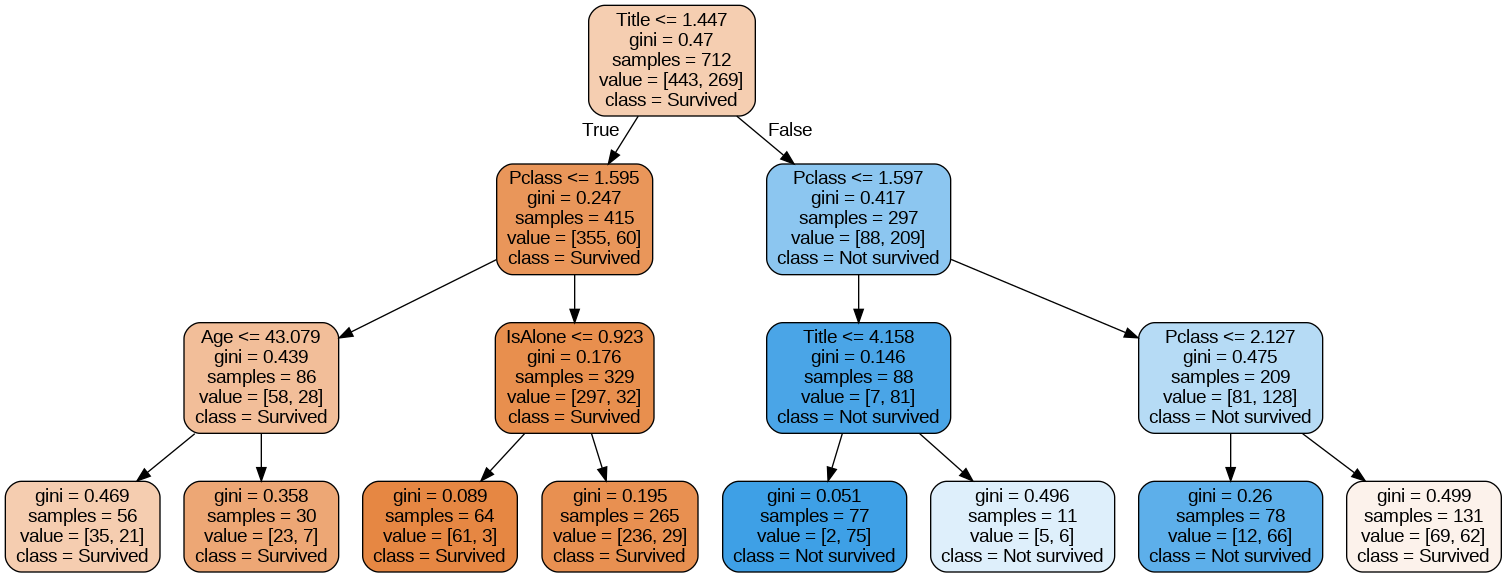

In [63]:
export_graphviz(
        tree_clf,
        out_file="titanic.dot",
        feature_names=feature_names,
        class_names=["Survived","Not survived"],
        rounded=True,
        filled=True
    )

#appel à la fonction dot de graphwiz
os.system("dot -Tpng titanic.dot -o titanic.png") 
#Affichage de l'image créée
Image("titanic.png")

2.5 Générez le fichier de résultats et envoyer une soumission sur Kaggle

In [75]:
generer_resultats(tree_clf, dataframe_test)

NameError: ignored

2.6 Question : Quel est votre meilleur score et Classement ?

## Exercice 3 : Random Forest
3.1 En utilisant l'exemple 5, Réalisez un algorithme de Random Forest sur les données Titanic. <br>

In [67]:
# Définir les hyperparamètres de la Random Forest
n_estimators = 100 # nombre d'arbres dans la forêt
max_depth = 5 # profondeur maximale des arbres
random_state = 42 # initialisation aléatoire pour la reproductibilité

# Créer un classifieur Random Forest avec les hyperparamètres définis
rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

# Entraîner la Random Forest sur les données d'apprentissage
rf_clf.fit(X_train, y_train)

# Prédire les labels pour les données de développement
y_dev_pred = rf_clf.predict(X_dev)

# Calculer le score d'exactitude pour les données de développement
accuracy = accuracy_score(y_dev, y_dev_pred)

# Afficher le score d'exactitude
print("Score d'exactitude sur les données de développement : {:.2f}%".format(accuracy*100))

Score d'exactitude sur les données de développement : 78.21%


3.2 Classez les features par ordre d'importance.

In [68]:
importances = rf_clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1] # trier les indices des features par ordre décroissant d'importance
sorted_features = [feature_names[i] for i in sorted_indices] # trier les noms de features par ordre décroissant d'importance
print("Ordre des features par importance :")
for f in sorted_features:
    print("- {}".format(f))

Ordre des features par importance :
- Title
- Sex
- Fare
- Pclass
- Age
- Embarked
- IsAlone


3.3 Tester dans une boucle différentes valeurs pour max_depth et max_features de l'arbre et pour le nombre d'estimateurs.

In [69]:
# Initialiser les variables pour stocker les meilleurs hyperparamètres et score
best_max_depth = None
best_max_features = None
best_n_estimators = None
max_accuracy = 0.0

# Boucle pour tester différentes combinaisons d'hyperparamètres
for max_depth in range(7,20):
    for max_features in ['sqrt','log2']: # 
        for n_estimators in range(40,60):
            # Créer un classifieur Random Forest avec les hyperparamètres actuels
            rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=42)
            
            # Entraîner la Random Forest sur les données d'apprentissage
            rf_clf.fit(X_train, y_train)
            
            # Prédire les labels pour les données de développement
            y_dev_pred = rf_clf.predict(X_dev)
            
            # Calculer le score d'exactitude pour les données de développement
            accuracy = accuracy_score(y_dev, y_dev_pred)
            
            # Si le score d'exactitude est supérieur au maximum actuel, stocker les hyperparamètres correspondants
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                best_max_depth = max_depth
                best_max_features = max_features
                best_n_estimators = n_estimators

# Afficher les meilleurs hyperparamètres et le score d'exactitude correspondant
print("Meilleurs hyperparamètres : max_depth={}, max_features={}, n_estimators={}".format(best_max_depth, best_max_features, best_n_estimators))
print("Score d'exactitude sur les données de développement : {:.2f}%".format(max_accuracy*100))

Meilleurs hyperparamètres : max_depth=7, max_features=sqrt, n_estimators=41
Score d'exactitude sur les données de développement : 80.45%


In [71]:
rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, max_features=best_max_features)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=41)

3.4 Générer un fichier et envoyer les résultats sur Kaggle. Ecrivez ici vos résultats.

In [73]:
generer_resultats(rf_clf, dataframe_test)

NameError: ignored

3.5 En utilisant la fonction plot_decision_boundary, afficher les résultats pour de l'arbre seul et du modèle de forêt les variables Fare et Age
Au moins 3 arguments sont attendus.
    clf : Classifier à afficher (Il doit être entraîné sur les 2 variables Fare et Age)
    X : features de Données a afficher
    y : labels de Données a afficher  

In [74]:
max_accuracy = 0
best_depth = 1
best_estim = 1

for i in range(1,100):
  print(i)
  for y in range(1,10):

    rf_clf = RandomForestClassifier(n_estimators=i, max_depth=y)
    rf_clf.fit(X_train[:, [2, 3]], y_train)

    # Prédire les labels pour les données de développement
    y_dev_pred = rf_clf.predict(X_dev[:, [2, 3]])
            
    # Calculer le score d'exactitude pour les données de développement
    accuracy = accuracy_score(y_dev, y_dev_pred)
            
    # Si le score d'exactitude est supérieur au maximum actuel, stocker les hyperparamètres correspondants
    if accuracy > max_accuracy:
      max_accuracy = accuracy
      best_depth = y
      best_estim = i

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## Exercice 4 : Boosting
4.1 En vous inspirant de l'exemple 6, Testez ici Adaboost

4.2 Afficher les résultats. Essayer differents paramètres de max depth, nombre d'estimateurs, taille des arbres ...

4.3 Appliquer le "Early Stopping" sur le nombre d'estimateurs. Comparer avec le résultat sans Early Stopping. 

4.4 Générer un fichier et envoyer les résultats sur Kaggle. Ecrivez ici vos résultats.

4.5 Relancer les modèles de Gradient Boosting avec et sans Early Stopping, en n'utilisant que les variables Age et Fare.

4.6 Afficher les résultats avec et sans Early Stopping avec la fonction plot_decision_boundary